# 트랜스폼 정의 & 샘플 시각화

In [1]:
import os

# 현재 작업 디렉토리 확인
print("현재 작업 디렉토리:", os.getcwd())

# 노트북이 위치한 디렉토리에서 프로젝트 루트 디렉토리로 이동
# 'notebooks/EDA' 에서 'AI_Lab/computer-vision-competition-1SEN' 으로 이동
os.chdir("../../") 

# 작업 디렉토리 변경 후 다시 확인
print("변경 후 작업 디렉토리:", os.getcwd())

현재 작업 디렉토리: /home/ieyeppo/AI_Lab/computer-vision-competition-1SEN/notebooks/EDA
변경 후 작업 디렉토리: /home/ieyeppo/AI_Lab/computer-vision-competition-1SEN


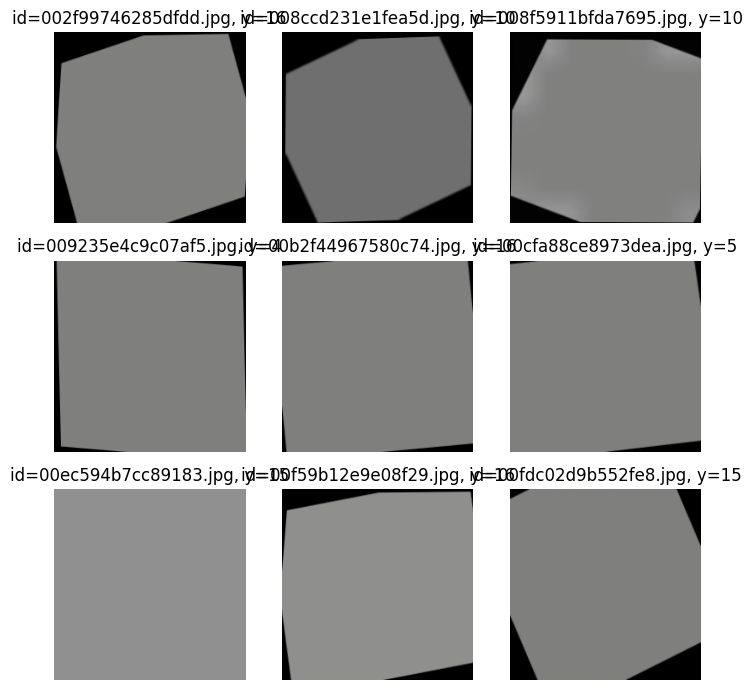

In [3]:
# 01_transforms_gallery.ipynb — 시각화 셀 (교체본)

import os, json, numpy as np                        # OS, JSON 처리, 수치 계산
import pandas as pd                                 # CSV 로드/데이터프레임 처리
import matplotlib.pyplot as plt                     # 시각화 라이브러리

from src.data.transforms import get_train_transforms, get_val_transforms  # 변환 함수
from src.data.dataset import DocTypeDataset         # 커스텀 Dataset 클래스

# 1) 설정 로드 (checks.py가 절대경로로 저장해둔 결과 활용)
CFG = json.load(open("configs/data_config.json", "r", encoding="utf-8"))
train_csv = CFG["paths"]["train_csv"]               # 학습 CSV 경로
img_root  = CFG["paths"]["train_root"]              # 학습 이미지 루트

# 파일 인덱스 JSON (확장자/대소문자 해결)
file_index_train = os.path.join(
    CFG["paths"]["processed_dir"],                  # 전처리된 이미지 디렉터리
    "file_index_train.json"                         # 파일 인덱스 JSON 파일
)

# 2) 변환 정의
size = CFG["loader"]["img_size"]                    # 이미지 크기
tr = get_train_transforms(size, CFG.get("augs", {}))# 학습용 변환
va = get_val_transforms(size)                       # 검증용 변환

# 3) 데이터셋 생성 (파일 인덱스 전달 → 확장자/대소문자 차이 해결)
ds = DocTypeDataset(
    csv_path=train_csv,                             # 학습 CSV
    img_root=img_root,                              # 이미지 루트
    mode="train",                                   # 학습 모드
    transform=tr,                                   # 학습용 변환 적용
    return_id=True,                                 # ID 반환
    file_index_path=file_index_train,               # 파일 인덱스 경로
)

# 4) 디노말라이즈 함수 (채널별 mean/std 반영)
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)  # 평균값
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)  # 표준편차

# 텐서를 numpy 이미지로 변환 (시각화용)
def to_numpy_image(t):
    """C,H,W Tensor -> H,W,C [0,1] float 이미지"""
    x = t.detach().cpu().permute(1, 2, 0).numpy()   # Tensor → numpy 변환
    x = (x * IMAGENET_STD + IMAGENET_MEAN).clip(0.0, 1.0)  # 디노말라이즈
    return x                                        # 결과 반환

# 5) 3x3 샘플 시각화
fig, axes = plt.subplots(3, 3, figsize=(7, 7))      # 3x3 서브플롯 생성
for ax, i in zip(axes.ravel(), range(9)):           # 9개 샘플 반복
    x, y, _id = ds[i]                               # 데이터셋에서 샘플 로드
    ax.imshow(to_numpy_image(x))                    # 디노말라이즈 후 시각화
    ax.set_title(f"id={_id}, y={y}")                # 제목: ID와 라벨
    ax.axis("off")                                  # 축 제거
plt.tight_layout()                                  # 레이아웃 자동 조정
plt.show()                                          # 플롯 출력
